In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
path1 = "/content/gdrive/MyDrive/Train/diseased"

In [4]:
path2 = "/content/gdrive/MyDrive/Train/healthy"

In [5]:
import os
train = []
test = []
l = [0,0]

c = 0

for filename in os.listdir(path1):
  filename = path1 + "/" + filename
  if c > 564:
    l[0] = 1
    test.append([filename,l])
    c += 1
  else:
    l[0] = 1
    train.append([filename,l])
    c += 1

    

In [7]:
import os
l = [0,0]

c = 0

for filename in os.listdir(path2):
  filename = path2 + "/" + filename
  if c > 654:
    l[1] = 1
    test.append([filename,l])
    c += 1
  else:
    l[1] = 1
    train.append([filename,l])
    c += 1

In [11]:
class Dataset(Dataset):
    

    def __init__(self, train, root_dir, transform=None):
        
        self.landmarks_frame = train
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        
        img_name = os.path.join(self.root_dir,self.landmarks_frame[idx][0])
        image = cv2.imread(img_name)
        y = torch.tensor(self.landmarks_frame[idx][1])
        y = y.float()
        
        

        if self.transform:
            image = self.transform(image)

        return (image,y)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import cv2
import glob
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset

In [12]:
print(len(train))

1220


In [13]:
print(len(test))

519


In [14]:
train[0][0]

'/content/gdrive/MyDrive/Train/diseased/151.jpg'

In [15]:
train_dataset = Dataset(train = train,root_dir='', transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224, transforms.InterpolationMode.BICUBIC),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

]))

In [16]:
test_dataset = Dataset(train = test,root_dir='', transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224, transforms.InterpolationMode.BICUBIC),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

]))

In [17]:
num_classes = 2
batch_size = 8
num_epochs = 10

In [18]:
trainloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

testloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

In [19]:
model_name = "resnet"
feature_extract = True

In [20]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
      for name, child in model.named_children():
        if name in ['layer3', 'layer4']:
          for param in child.parameters():
            param.requires_grad = True
        else:
          for param in child.parameters():
              param.requires_grad = False

In [21]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    
    if model_name == "resnet":
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    return model_ft, input_size


model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

print(model_ft)
print(input_size)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)

Params to learn:
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.bn2.weight
	 layer3.1.bn2.bias
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [24]:
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [26]:
losses = []

In [27]:
def train_model(model):

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        model.train()
        running_loss = 0.0

        for inputs, labels in trainloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
 

 
            optimizer.zero_grad()


            with torch.set_grad_enabled(True):
            
              outputs = model(inputs)
    
              loss = criterion(outputs, labels)

              _, preds = torch.max(outputs, 1)
              loss.backward()
              optimizer.step()


            running_loss += loss.item() * inputs.size(0)
              

        epoch_loss = running_loss / len(trainloader.dataset)
        print('Loss: {:.4f} '.format(epoch_loss))
        losses.append(epoch_loss)

In [28]:
train_model(model_ft)

Epoch 0/9
----------
Loss: 0.2714 
Epoch 1/9
----------
Loss: 0.0847 
Epoch 2/9
----------
Loss: 0.0529 
Epoch 3/9
----------
Loss: 0.0359 
Epoch 4/9
----------
Loss: 0.0206 
Epoch 5/9
----------
Loss: 0.0624 
Epoch 6/9
----------
Loss: 0.0375 
Epoch 7/9
----------
Loss: 0.0122 
Epoch 8/9
----------
Loss: 0.0674 
Epoch 9/9
----------
Loss: 0.0995 


In [3]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Number of Epochs')

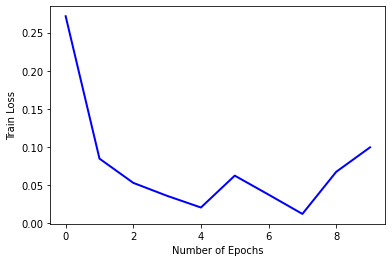

In [4]:
plt.plot( losses,color='blue', label= "Train_Loss", linewidth=2)
plt.ylabel('Train Loss')
plt.xlabel('Number of Epochs')

In [29]:
Predicted = []
Lab = []

In [30]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:

        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model_ft(images)


        _, predicted = torch.max(outputs, 1)

        _, lab = torch.max(labels , 1)
        for x in range(len(predicted)):
          Predicted.append(int(predicted[x]))
          Lab.append(int(lab[x]))

        total += labels.size(0)
        correct += (predicted == lab).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 95 %


In [32]:
from sklearn.metrics import classification_report
y_true = Lab
y_pred = Predicted
target_names = ['class' + str(x) for x in range(2)]
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      class0       0.93      0.98      0.95       240
      class1       0.98      0.94      0.96       279

    accuracy                           0.96       519
   macro avg       0.96      0.96      0.96       519
weighted avg       0.96      0.96      0.96       519

